# matchtesting算出matrix

In [49]:
import cv2, numpy as np
import json,math,os
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import os
import otherdemos.resize as r
from otherdemos.resize import check2map,check1map,plt_show

## 输入

In [50]:
target_image = cv2.imread("./picc.png",)
# images_folder="./data/240415/captured/position_00a/" 05221947 倾斜 05142104  好 05102118 最好05111000 05110957
images_folders=["./data/05111000/captured/position_00/","./data/05110957/captured/position_00/"]
# images_folders=["./data/05072039/captured/position_00/","./data/05072033/captured/position_00/"]
realarpath=r"C:\Users\Administrator\Desktop\a.txt"
match_np_path="./result/match.npy"
# pro_size = (640, 480) # Projector image plane size
pro_size = (1280, 720) # Projector image plane size
cam_size = (1920, 1080) # Camera image plane size
projector_id=0
#是否全部可视化
allvisualization=False


In [51]:
captured_gray_image_all = []
proconf=[]
i=0
for images_folder in images_folders:
    images =r.load_images_from_folder(images_folder)
    if images is not None:
        captured_gray_image_all.append(images)
        proconf.append(i)
        i=i+1
captured_gray_images=captured_gray_image_all[projector_id]

## Gray解码

### 1. Gray过滤出匹配点并记录


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


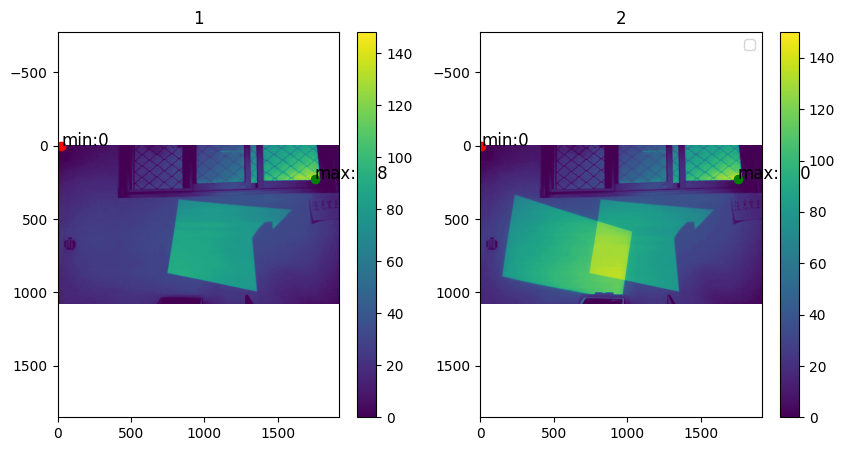

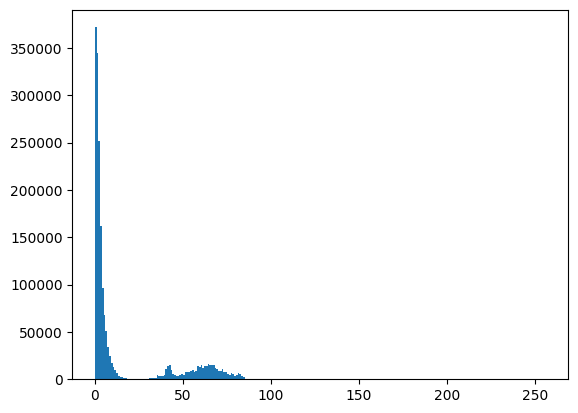

In [52]:
n_cols, n_rows = r.computeNumberOfPatternImages(pro_size[0], pro_size[1])
#根据投影图像的尺寸log2再*2互补，计算出需要多少张互补格雷码图像来完全编码这个空间
n_patterns = n_cols + n_rows#1920*1080下22+22=44  张图片
black_img, white_img = captured_gray_images[n_patterns:n_patterns + 2]
if 1:
    check2map(black_img,white_img)
shadow_mask = white_img.astype(np.int32) - black_img.astype(np.int32)
if 1:
    # shadow_thresh=check1map(shadow_mask)/3
    shadow_thresh=20

plt.figure()
plt.hist(shadow_mask.ravel(), 256, [0, 256])
plt.show()


In [53]:
shadow_mask = np.greater(shadow_mask, shadow_thresh)#shadow_thresh
shadow_mask = shadow_mask.astype(np.uint8) * 255
# 先腐蚀再膨胀以变成比较规整的多边形
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
eroded = cv2.erode(shadow_mask, kernel, iterations=1)
dilated = cv2.dilate(eroded, kernel, iterations=1)
shadow_mask= dilated

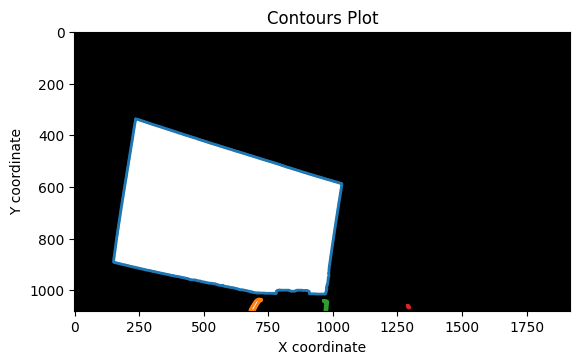

In [54]:
plt.imshow(shadow_mask, cmap='gray')
r.findcontours(shadow_mask)

#### 用全白-全黑剩余 

In [55]:
code_thresh=0#减小之后点会增多
gray_col_stack = np.stack(captured_gray_images[0:n_cols:2]).astype(np.int32) - np.stack(captured_gray_images[1:n_cols:2]).astype(np.int32)
#这两行代码提取捕获的灰度图像序列 captured_gray_images 中偶数列的像素值，并将其堆叠成一个新的数组 gray_col_stack 。然后，再提取奇数列的像素值，并与偶数列的像素值相减，得到列方向的差值，并转为 int32 类型。
gray_row_stack = np.stack(captured_gray_images[n_cols:n_cols+n_rows:2]).astype(np.int32) - np.stack(captured_gray_images[n_cols+1:n_cols+n_rows:2]).astype(np.int32)

gray_col = np.greater(gray_col_stack, 0)
gray_row = np.greater(gray_row_stack, 0)

dec_mask_col = np.greater(np.abs(gray_col_stack), code_thresh)
dec_mask_row = np.greater(np.abs(gray_row_stack), code_thresh)

dec_mask_col = np.logical_and.reduce(dec_mask_col, axis=0)
dec_mask_row = np.logical_and.reduce(dec_mask_row, axis=0)


dec_mask = np.logical_and(dec_mask_col, dec_mask_row)
mask = np.logical_and(dec_mask, shadow_mask)

if 0:
    r.checkcol(gray_col_stack)
    r.checkcol(gray_col)#竖条的
    r.checkcol(gray_row)



### 2.用gray码生成投影机Gray到相机捕获图像点cmr_match_pjt字典

![image.png](doc\graydecode.png)


In [56]:
from method.decode_gray import gray_decoder# 将一个格雷码Gray编码的数字解码为其对应的十进制数。
def cmrmatchpjt(mask):
    cmr_match_pjt = {}
    for i in range(mask.shape[1]):   #长1280
        for j in range(mask.shape[0]):   #宽720
            # if 1:
            if mask[j, i]:
                xDec = gray_decoder(gray_col[:, j, i])
                yDec = gray_decoder(gray_row[:, j, i])
                if xDec < pro_size[0] and yDec < pro_size[1]:
                    prj_idx = (projector_id, xDec, yDec)
                    # Projector number and matched coordinates
                    if prj_idx not in cmr_match_pjt:
                        cmr_match_pjt[prj_idx] = []
                    cmr_match_pjt[prj_idx].append((i, j))
    #cmr_match_pjt: 一个字典，键是由投影仪编号和解码后的投影仪图像平面坐标组成的元组，如(0, 1726, 427)
    # 值是一个列表，包含了对应于这些投影仪坐标的相机图像平面上的点的坐标
    # 如  546,   216
    # cmrdictdir='./result/data.txt'
    #test_dict =  {str(key): value for key, value in cmr_match_pjt.items()}\
    # # 将字典转换为JSON格式的字符串，并保存到文件
    # with open(cmrdictdir, 'w', encoding='utf-8') as f:
    #     json.dump(test_dict, f, indent=4, ensure_ascii=False)
    return cmr_match_pjt

cam_match_pro=cmrmatchpjt(mask)



## 建立投影机图像平面坐标与投影图像像素坐标的匹配
= relation(anchors, cmr_match_pjt, ph_coordinate, pro_size, cam_size)


### 4.在投影仪的图像平面坐标和cam图像平面坐标之间建立一一对应的关系。
目标map_x, map_y 

输入cmr_match_pjt通过插值方法实现这一点，并返回一个包含映射信息的矩阵。


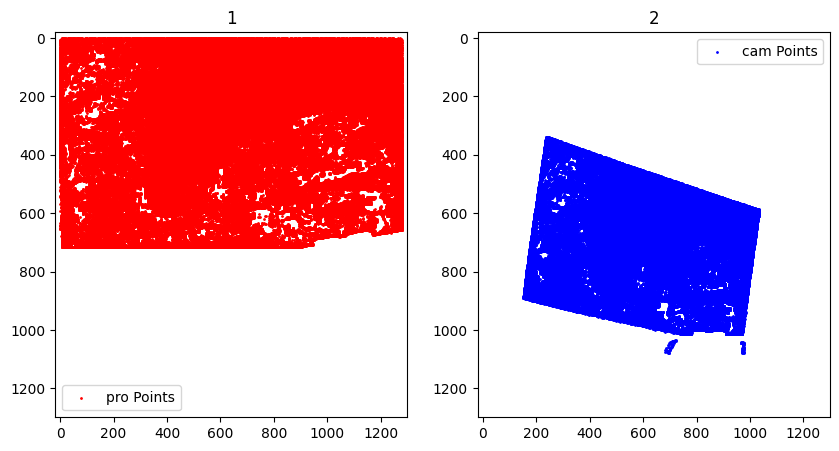

In [57]:
# The matching of each point in the image plane of the projector and the camera is accomplished using interpolation, and unmatched points are recorded as Nan
pro_know = [] # The coordinates of the projection plane
cam_know = [] # The coordinates of the camera plane
for i in cam_match_pro:
    pro_know.append(i[1:])#i[1:]，代码获取了元组中的后两个元素（x和y坐标）
    cam_know.append(cam_match_pro[i][0])
# - 首先，函数遍历 cmr_match_pjt 中的每个条目，将投影仪平面的坐标和相机平面的坐标分别存储在 `pro_know` 和 `cam_know` 列表中。
pro_know = np.array(pro_know)
cam_know = np.array(np.array(cam_know).reshape(-1,2))#reshape(-1, 2)中的-1表示根据数组的大小自动确定该维度
r.check2scatter(pro_know,cam_know,True)

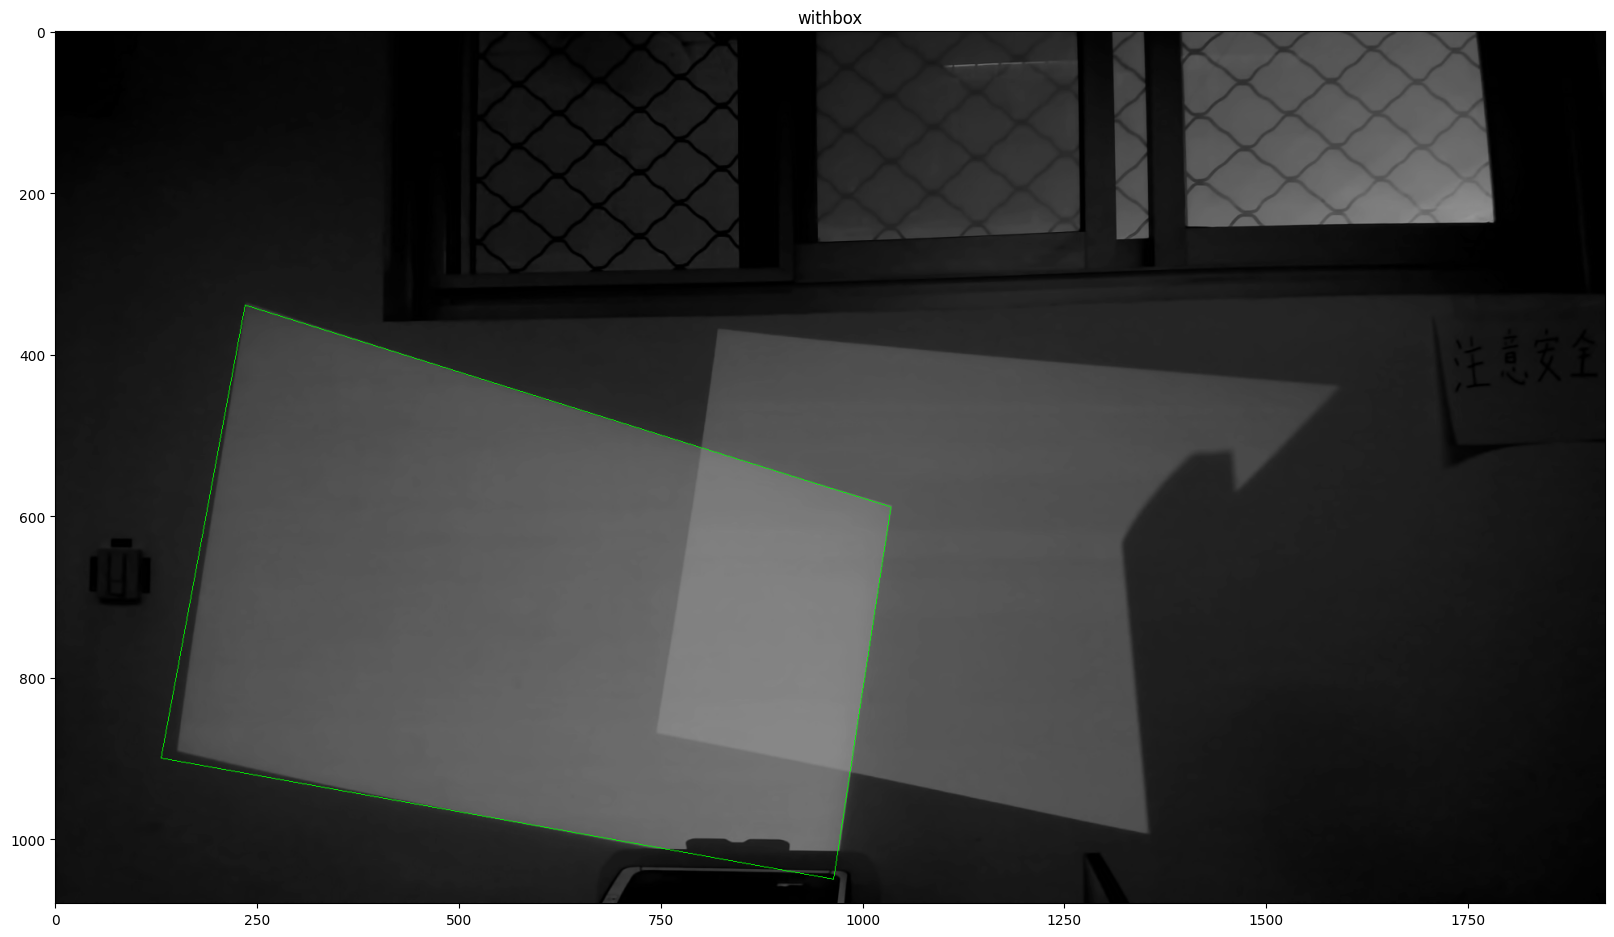

In [58]:
reprojThresh=-10
(H, status) = cv2.findHomography(pro_know, cam_know, cv2.RANSAC, reprojThresh)

# result = cv2.warpPerspective(target_image, H, (cam_size[0], cam_size[1]))
# plt_show('result', result)
# img = np.ones((pro_size[1],pro_size[0]), dtype=np.uint8)*255
# img= cv2.warpPerspective(img, H, (cam_size[0], cam_size[1]))
# check2map(white_img,img)

pt1=r.fourdotclock((pro_size[0],pro_size[1]))
# pt1=r.fourdotclock((640,360))
pt1=cv2.perspectiveTransform(pt1.reshape(-1, 1, 2),H).reshape(-1,2)
# Save the transformed 4-point coordinates to a text file
with open('transformed_coordinates.txt', 'w') as file:
    for point in pt1:
        file.write(f'{point[0]}, {point[1]}\n')

r.plt_show_withbox(white_img,pt1.reshape(-1,2))

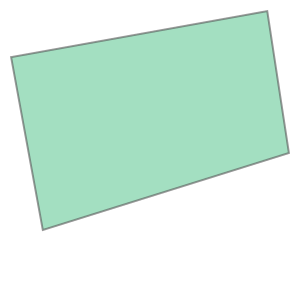

In [59]:
from shapely.geometry import Polygon
polygon1=Polygon(pt1)
polygon1


In [60]:

# import cv2,numpy as np
# w,h,ww,hh=500,500,1000,1000

# pt2 = np.array([[w,h],[ww,h],[ww,hh],[w,hh]])
# (H, status) = cv2.findHomography(pt2, pt1)
# #(target_image.shape[1], target_image.shape[0])
# # target_image=cv2.imread("pic1280_720.jpg")
# np.linalg.inv(H)
# result = cv2.warpPerspective(target_image, np.linalg.inv(H),pro_size )
# cv2.imwrite("1.png",result)
# plt_show("0",result)

In [61]:
# Interpolation to achieve a one-to-one correspondence between the projection plane and the camera plane results are stored in cam_pro
# (how the points in pro are filled into cam)
#插值实现投影平面和相机平面的一对一对应结果存储在cam_pro中
grid_x = np.linspace(0, cam_size[0]-1, cam_size[0])  # x coordinate range
grid_y = np.linspace(0, cam_size[1]-1, cam_size[1])  # y coordinate range

grid_x, grid_y = np.meshgrid(grid_x, grid_y)
if allvisualization:
    check2map(grid_x,grid_y)
points_to_remap = np.column_stack((grid_x.flatten(), grid_y.flatten()))

In [62]:
from otherdemos.resize import check2scatter
pt1=r.dotmatrix((pro_size[0],pro_size[1]),16,9)



In [63]:
# # Check input dimensions
# if len(cam_know.shape) != 2 or cam_know.shape[1] != 2:
#     raise ValueError("`cam_know` must be a 2D array with shape (num_points, 2)")
# if shadow_mask.ndim != 2:
#     raise ValueError("`shadow_mask` must be a 2D array (grayscale or binary image)")

# # Ensure shadow_mask has expected values (0 or 1)
# if not np.all(np.isin(shadow_mask.flatten(), [0, 1])):
#     raise ValueError("`shadow_mask` elements must be either 0 or 1")

# # Reshape shadow_mask if necessary (assuming it's grayscale)
# if shadow_mask.shape[0] != cam_know.shape[0] or shadow_mask.shape[1] != cam_know.shape[1]:
#     shadow_mask = shadow_mask.reshape(cam_know.shape[0], cam_know.shape[1])

# filtered_cam_know = cam_know[shadow_mask!=0,:]

campro是一个很稀疏的矩阵

[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
(2073600, 2)
Non-NaN count: 937152
Non-NaN ratio: 22.60%
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


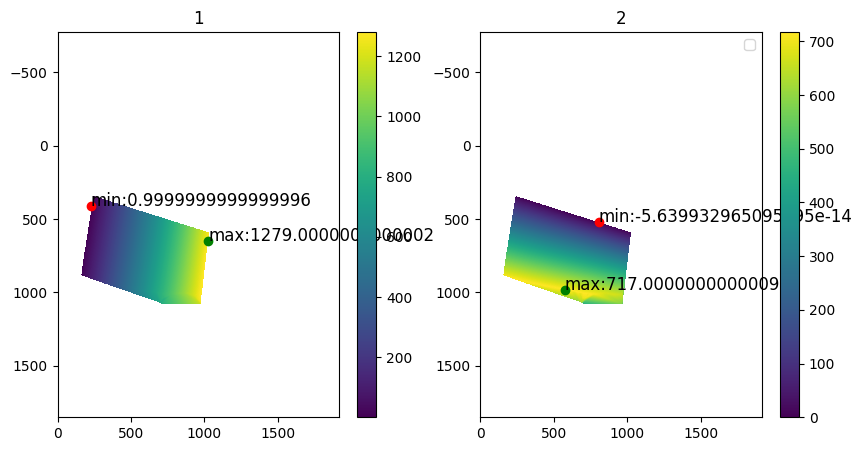

In [64]:
#函数将 cam_know 中的点映射到 pro_know 中的点，通过插值方法填充整个相机图像平面，得到 cam_pro。
# 使用RANSAC方法过滤离群点
from sklearn.linear_model import RANSACRegressor
ransac_regressor = RANSACRegressor()
ransac_regressor.fit(cam_know, pro_know)
inlier_mask = ransac_regressor.inlier_mask_
filtered_cam_know = cam_know#[inlier_mask]
filtered_pro_know = pro_know#[inlier_mask]
cam_pro = griddata(filtered_cam_know, filtered_pro_know, points_to_remap, method='linear')

scale_matrix = np.array([[1920/1280, 0, 0],
                         [0, 1080/720, 0],
                         [0, 0, 1]])

scale_matrix=np.linalg.inv(scale_matrix)
# cam_pro=cv2.perspectiveTransform(points_to_remap.reshape(-1, 1, 2),np.linalg.inv(H)).reshape(-1,2)
# The 'method' parameter in the griddata function specifies the interpolation method to use. Some common methods include:
# - 'linear': Linear interpolation
# - 'nearest': Nearest-neighbor interpolation
# - 'cubic': Cubic interpolation
# - 'quintic': Quintic interpolation
# - 'linearND': Linear interpolation in N dimensions
# - 'cubicND': Cubic interpolation in N dimensions
if 0:

    plt.scatter(points_to_remap[:,0], points_to_remap[:,1], c='blue')
    plt.scatter(cam_pro[:,0], cam_pro[:,1], c='red')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mapping from points_to_remap to cam_pro')
    plt.show()
    # 取前10个点
    # 找到非nan的索引
    non_nan_idx = np.where(~np.isnan(cam_pro))[0]
    # 取前10个非nan点
    points = cam_pro[non_nan_idx[:10]]
    # 绘制点并添加标号
    plt.scatter(points[:,0], points[:,1])
    for i in range(len(points)):
        plt.annotate(i, (points[i,0], points[i,1]))
    plt.title('the first 10 noNaN points cam_pro')
    plt.show()

print(cam_pro)
print(cam_pro.shape)

non_nan_count = np.count_nonzero(~np.isnan(cam_pro))
total_count = np.prod(cam_pro.shape)
non_nan_ratio = non_nan_count / total_count

print(f"Non-NaN count: {non_nan_count}")
print(f"Non-NaN ratio: {non_nan_ratio:.2%}")
map_x = np.zeros([cam_size[1], cam_size[0]], dtype=float)
map_y = np.zeros([cam_size[1], cam_size[0]], dtype=float)
print(map_x)
for idx, num in enumerate(cam_pro):
    map_x[idx // cam_size[0]][idx % cam_size[0]] = num[0]
    map_y[idx // cam_size[0]][idx % cam_size[0]] = num[1]
#这段代码片段基于索引将插值点从cam_pro映射到map_x和map_y矩阵。
#它将每个点的x坐标分配给map_x, y坐标分配给map_y
map_x, map_y = map_x.reshape(-1, map_x.shape[0], map_x.shape[1]), map_y.reshape(-1, map_x.shape[0], map_x.shape[1])
#将二维数组 map_x 调整形状为三维
matrix = np.concatenate((map_x, map_y), axis=0)
check2map(matrix[0],matrix[1])


## Aruco建立真实世界坐标与相机坐标和像素坐标

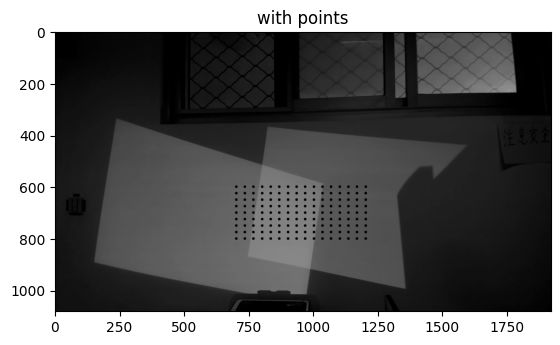

In [65]:
anchors = {} # Aruco代码中投影图像的坐标及其对应的id
corners2 = []
# Aruco代码中投影图像的坐标及其对应的id
# rnp = np.loadtxt(realarpath, encoding='utf-8', dtype=float)
rnp = np.array([[700,600], [1200,800]])

for index, value in enumerate(rnp):
    corners2.append([value[0], value[1]])
# Extract the coordinates of the rectangle from corners2
top_left = [min(corners2[0][0], corners2[1][0]), min(corners2[0][1], corners2[1][1])]
bottom_right = [max(corners2[0][0], corners2[1][0]), max(corners2[0][1], corners2[1][1])]

# Calculate the dimensions of the rectangle
rect_width = bottom_right[0] - top_left[0]
rect_height = bottom_right[1] - top_left[1]

# Define the number of lines horizontally and vertically
markX = 16
markY = 9

# Calculate the spacing between the grid lines
spacing_horizontal = rect_width / (markX - 1)
spacing_vertical = rect_height / (markY - 1)

# Generate the grid points
grid_points = []
for i in range(markY):
    for j in range(markX):
        grid_x = top_left[0] + j * spacing_horizontal
        grid_y = top_left[1] + i * spacing_vertical
        grid_points.append([grid_x, grid_y])
r.plt_show_pts(white_img,grid_points)

for idx, point in enumerate(grid_points):
    anchors[idx] = point


# 投影机图像与real中校准点的匹配

查找matrix得到的投影图像与real图像中的校准点的匹配程度

# 投影机图像与待投影图像的校准点的匹配

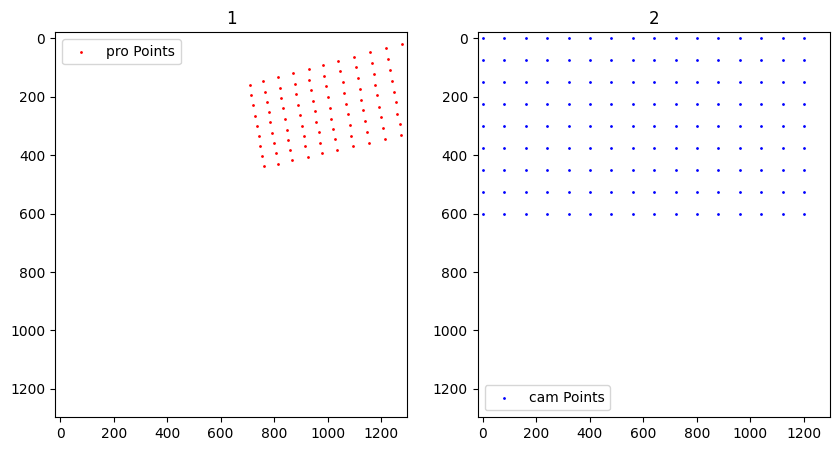

In [66]:
def pro_real_match(matrix, anchors):

    # 投影机图像平面与投影图像中校准点的匹配
    cam_know = [] # The position of the Aruco code in the image plane of the camera
    dotmatrixbycsharp = [] #框选点 原来的idx_Aruco  Aruco code number
    for key, value in anchors.items():
        cam_know.append(np.array([int(value[1]), int(value[0])]))
        dotmatrixbycsharp.append(key)
    cam_know = np.array(cam_know)
    # 投影图像平面和投影图像Matching of projector image plane and projected image
    pro_real = {} # 点的坐标对应于投影仪中的像素点。The coordinates of the points corresponding to the pixel points in the projector.
    for n, m in enumerate(cam_know):
        pro_real[dotmatrixbycsharp[n]] = np.array([(matrix[0][m[0]][m[1]]), (matrix[1][m[0]][m[1]])])
    # Reading calibrated projected image coordinates
    real_dic = {} # Aruco代码中投影图像的坐标及其对应的id
    #Aruco代码中投影图像的坐标及其对应的id
    copytxt = r.dotmatrix(target_image.shape[:2],markY,markX)
    for idx,i in enumerate(copytxt):
        real_dic[idx] = [i[0], i[1]]
    pro = [] #投影仪中与投影图像相匹配的点的像素坐标
    real = [] # Pixel coordinates of points where the projected image matches the projector
    #real图像与投影仪相匹配的点的像素坐标
    # 记录投影平面和投影图像的匹配关系
    for key, value in pro_real.items():
        pro.append(value)
        real.append(real_dic[key])
    pro = np.array(pro)
    real = np.array(real)
    check2scatter(pro, real,True)
    return pro,real
pro,real=pro_real_match(matrix, anchors)

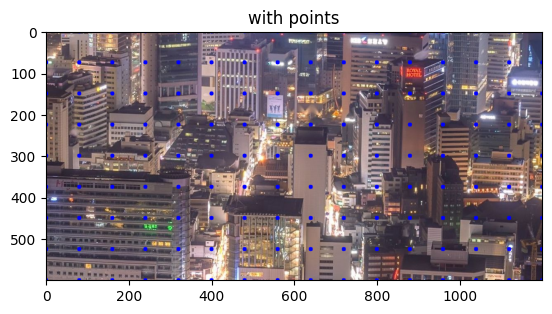

In [67]:
r.plt_show_pts(target_image,real,(255,0,0))


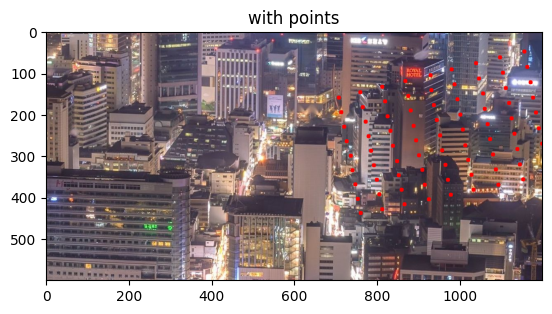

In [68]:
r.plt_show_pts(target_image,pro)

### 预测投影机图像平面与投影图像中校准点匹配失败之间的匹配



[[  0.   0.]
 [ 80.   0.]
 [160.   0.]
 [240.   0.]
 [320.   0.]
 [400.   0.]
 [480.   0.]
 [560.   0.]
 [640.   0.]
 [720.   0.]
 [800.   0.]
 [  0.  75.]
 [ 80.  75.]
 [160.  75.]
 [240.  75.]
 [320.  75.]
 [400.  75.]
 [480.  75.]
 [560.  75.]
 [640.  75.]
 [720.  75.]
 [  0. 150.]
 [ 80. 150.]
 [160. 150.]
 [240. 150.]
 [320. 150.]
 [400. 150.]
 [480. 150.]
 [560. 150.]
 [640. 150.]
 [720. 150.]
 [  0. 225.]
 [ 80. 225.]
 [160. 225.]
 [240. 225.]
 [320. 225.]
 [400. 225.]
 [480. 225.]
 [560. 225.]
 [640. 225.]
 [720. 225.]
 [  0. 300.]
 [ 80. 300.]
 [160. 300.]
 [240. 300.]
 [320. 300.]
 [400. 300.]
 [480. 300.]
 [560. 300.]
 [640. 300.]
 [720. 300.]
 [  0. 375.]
 [ 80. 375.]
 [160. 375.]
 [240. 375.]
 [320. 375.]
 [400. 375.]
 [480. 375.]
 [560. 375.]
 [640. 375.]
 [720. 375.]
 [  0. 450.]
 [ 80. 450.]
 [160. 450.]
 [240. 450.]
 [320. 450.]
 [400. 450.]
 [480. 450.]
 [560. 450.]
 [640. 450.]
 [720. 450.]
 [  0. 525.]
 [ 80. 525.]
 [160. 525.]
 [240. 525.]
 [320. 525.]
 [400. 525.]

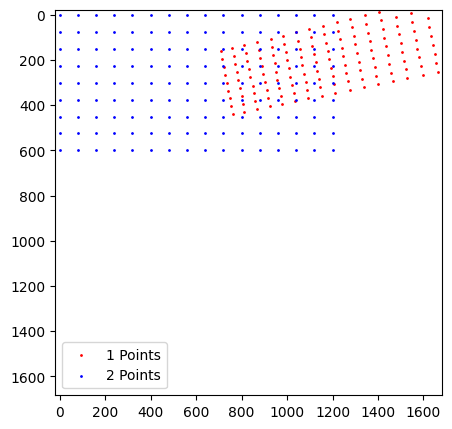

In [69]:

# Predicting the match between the projector image plane and the failure of the calibration points to match in the projected image
def predict_unknow(pro, real):
    pro_unknow = [] # Unknown point in projected coordinates
    real_unknow = [] # pro_unknow corresponds to the points in the projected image
    pro_know = [] # Projected coordinates of known points
    real_know = [] # pro_know corresponds to the point of the projected image
    for idx, num in enumerate(pro):
        if(math.isnan(num[0])):
            pro_unknow.append(num)
            real_unknow.append(real[idx])
        else:
            pro_know.append(num)
            real_know.append(real[idx])
    # Predicting the value of an unknown point by transformation
    if (len(real_unknow)!=0):
        pro_unknow = np.array(pro_unknow)
        real_unknow = np.array(real_unknow)
        pro_know = np.array(pro_know)
        real_know = np.array(real_know)
        print(real_know)

        print('the shape of pro_unknow:',pro_unknow.shape)
        print('the shape of real_unknow:',real_unknow.shape)
        transformational_matrix, _ = cv2.findHomography(real_know, pro_know) # transformation matrix
        pro_new = cv2.perspectiveTransform(real_unknow.reshape(-1, 1, 2), transformational_matrix).reshape(-1,2) # Predicted results
        # Record of the matching relationship between the calibration point (real_all) and the projector image plane (pro_all) point in projected images
        pro_all = np.vstack((pro_know,pro_new))
        real_all =  np.vstack((real_know,real_unknow))
    else:
        pro_all = np.array(pro_know)
        real_all =  np.array(real_know)
    check2scatter(pro_all, real_all)
    return pro_all, real_all
pro_all, real_all = predict_unknow(pro, real)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


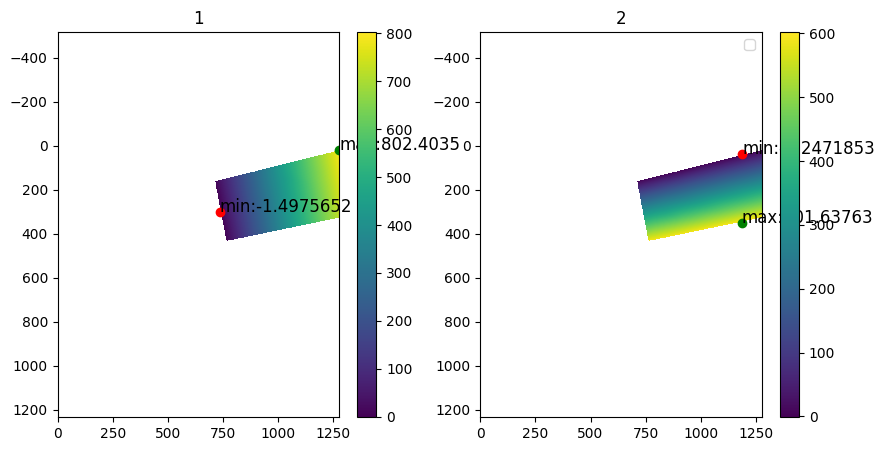

In [70]:

# One-to-one matching of projector image plane coordinates and projected image pixel coordinates
def get_matrix(pro_all, real_all, pro_size):
    # Determine how points in the image plane of the projector are projected into the projected image by interpolation
    grid_x = np.linspace(0, pro_size[0]-1, pro_size[0])
    grid_y = np.linspace(0, pro_size[1]-1, pro_size[1])
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    points_to_remap = np.column_stack((grid_x.flatten(), grid_y.flatten()))
    remapped_points = griddata(pro_all,real_all, points_to_remap, method='cubic')
    mapx = np.zeros([pro_size[1], pro_size[0]], dtype=float)
    mapy = np.zeros([pro_size[1], pro_size[0]], dtype=float)
    for idx, num in enumerate(remapped_points):
        mapx[idx // pro_size[0]][idx % pro_size[0]] = num[0]
        mapy[idx // pro_size[0]][idx % pro_size[0]] = num[1]
    mapx = np.float32(mapx)
    mapy = np.float32(mapy)
    return mapx, mapy
map_x, map_y = get_matrix(pro_all, real_all, pro_size)
check2map(map_x, map_y)

In [71]:


#传入Aruco标记的 anchors、解码得到的匹配信息 cmr_match_pjt、投影图像坐标 ph_coordinate、投影仪尺寸 pro_size 和相机尺寸 cam_size，计算出映射关系，得到 map_x 和 map_y
map_x, map_y = map_x.reshape(1, -1, map_x.shape[0], map_x.shape[1]), map_y.reshape(1, -1, map_x.shape[0], map_x.shape[1])
map_matrix = np.concatenate((map_x, map_y), axis=1)
np.save(match_np_path, map_matrix)

# Render

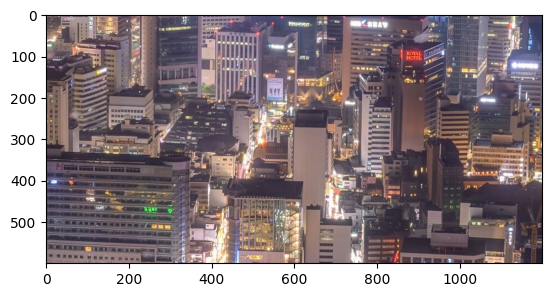

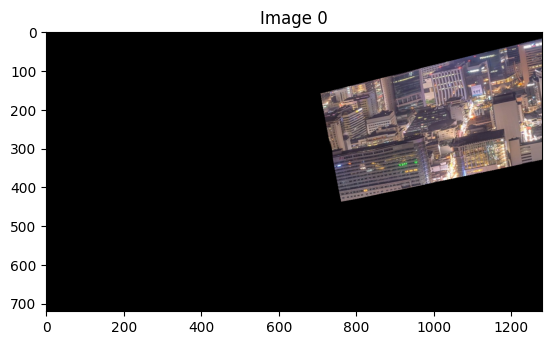

(2, 720, 1280)


In [72]:

# Resize the image to match the projector size
# target_image = cv2.resize(target_image, (pro_size[0], pro_size[1]))

map_matrixs = np.load(match_np_path)
# Corrects the projected image according to the matching result
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
plt.show()
for idx,map_matrix in enumerate(map_matrixs):
    part = cv2.remap(target_image, map_matrix[0], map_matrix[1], interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(f'{"./result/"}/{idx}.png', part)
    plt.imshow(cv2.cvtColor(part, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {idx}')
    plt.show()
print(map_matrix.shape)